# Platooning


## Model description

The platooning benchmark considers a platoon of three vehicles following each
other. This benchmark considers loss of communication between vehicles. The
initial discrete state is ``q_c``. Three scenarios are considered for the loss
of communication:


**PLAA01 (arbitrary loss)** The loss of communication can occur at any time. This
      includes the possibility of no communication at all.

**PLADxy (loss at deterministic times)** The loss of communication occurs at fixed
      points in time, which are determined by clock constraints $c_1$ and $c_2$.
      The clock t is reset when communication is lost and when it is re-established.
      Note that the transitions have must-semantics, i.e., they take place as soon
      as possible. We will consider $PLAD01: c_1 = c_2 = 5$.

**PLANxy (loss at nondeterministic times)** The loss of communication occurs at
      any time $t ∈ [t_b, t_c]$. The clock t is reset when communication is lost
      and when it is reestablished. Communication is reestablished at any time
      $t ∈ [0, t_r]$. This scenario covers loss of communication after an
      arbitrarily long time $t ≥ t_c$ by reestablishing communication in zero time.
      We will consider $PLAN01: t_b = 10, t_c = 20, t_r = 20$.

The Julia model is developed next. It's convenient to create two independent
functions, `platoon_connected` and `platoon_disconnected`, which describe the
dynamics of the connected (resp. disconnected) modes. These functions are
connected in the `platoon` function using a hybrid automaton with two modes
and two discrete transition, see figure below.

### Dynamics of the "connected" platoon

In [1]:
using Revise, ReachabilityAnalysis, SparseArrays, ModelingToolkit

const var = @variables x₁, x₂, x₃, x₄, x₅, x₆, x₇, x₈, x₉, t

function platoon_connected(; deterministic_switching::Bool=true,
                             c1=5.0)  # clock constraints
    n = 9 + 1

    # x' = Ax + Bu + c
    A = Matrix{Float64}(undef, n, n)
    A[1, :] = [0, 1.0, 0, 0, 0, 0, 0, 0, 0, 0]
    A[2, :] = [0, 0, -1.0, 0, 0, 0, 0, 0, 0, 0]
    A[3, :] = [1.6050, 4.8680, -3.5754, -0.8198, 0.4270, -0.0450, -0.1942,  0.3626, -0.0946, 0.]
    A[4, :] = [0, 0, 0, 0, 1.0, 0, 0, 0, 0, 0,]
    A[5, :] = [0, 0, 1.0, 0, 0, -1.0, 0, 0, 0, 0]
    A[6, :] = [0.8718, 3.8140, -0.0754,  1.1936, 3.6258, -3.2396, -0.5950,  0.1294, -0.0796, 0.]
    A[7, :] = [0, 0, 0, 0, 0, 0, 0, 1.0, 0, 0]
    A[8, :] = [0, 0, 0, 0, 0, 1.0, 0, 0, -1.0, 0]
    A[9, :] = [0.7132, 3.5730, -0.0964,  0.8472, 3.2568, -0.0876,  1.2726,  3.0720, -3.1356, 0.]
    A[10, :] = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0]; # t' = 1

    if deterministic_switching
        invariant = HalfSpace(t <= c1, var)
    else
        invariant = Universe(n)
    end

    # acceleration of the lead vehicle + time
    B = sparse([2], [1], [1.0], n, 1)
    U = Hyperrectangle(low=[-9.], high=[1.])
    c = [0, 0, 0, 0, 0, 0, 0, 0, 0, 1.0]
    @system(x' = Ax + Bu + c, x ∈ invariant, u ∈ U)
end

┌ Warning: Replacing docs for `LazySets.HPolyhedron :: Union{Tuple{Array{var"#s49",1} where var"#s49"<:Operation}, Tuple{Array{var"#s48",1} where var"#s48"<:Operation,Any}}` in module `LazySets`
└ @ Base.Docs docs/Docs.jl:227
┌ Warning: Replacing docs for `LazySets.HPolytope :: Union{Tuple{Array{var"#s49",1} where var"#s49"<:Operation}, Tuple{Array{var"#s48",1} where var"#s48"<:Operation,Any}}` in module `LazySets`
└ @ Base.Docs docs/Docs.jl:227


platoon_connected (generic function with 1 method)

### Dynamics of the "disconnected" platoon

In [2]:
function platoon_disconnected(; deterministic_switching::Bool=true,
                                c2=5.0)  # clock constraints
    n = 10 # 9 dimensions + time

    # x' = Ax + Bu + c
    A = Matrix{Float64}(undef, n, n)
    A[1, :] = [0, 1.0, 0, 0, 0, 0, 0, 0, 0, 0]
    A[2, :] = [0, 0, -1.0, 0, 0, 0, 0, 0, 0, 0]
    A[3, :] = [1.6050, 4.8680, -3.5754, 0, 0, 0, 0, 0, 0, 0]
    A[4, :] = [0, 0, 0, 0, 1.0, 0, 0, 0, 0, 0,]
    A[5, :] = [0, 0, 1.0, 0, 0, -1.0, 0, 0, 0, 0]
    A[6, :] = [0, 0, 0,  1.1936, 3.6258, -3.2396, 0, 0, 0, 0.]
    A[7, :] = [0, 0, 0, 0, 0, 0, 0, 1.0, 0, 0]
    A[8, :] = [0, 0, 0, 0, 0, 1.0, 0, 0, -1.0, 0]
    A[9, :] = [0.7132, 3.5730, -0.0964,  0.8472, 3.2568, -0.0876,  1.2726,  3.0720, -3.1356, 0.]
    A[10, :] = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0]; # t' = 1

    if deterministic_switching
        invariant = HalfSpace(t <= c2, var)
    else
        invariant = Universe(n)
    end

    #acceleration of the lead vehicle + time
    B = sparse([2], [1], [1.0], n, 1)
    U = Hyperrectangle(low=[-9.], high=[1.])
    c = [0, 0, 0, 0, 0, 0, 0, 0, 0, 1.0]
    @system(x' = Ax + Bu + c, x ∈ invariant, u ∈ U)
end

platoon_disconnected (generic function with 1 method)

### Hybrid system

In [3]:
function platoon(; deterministic_switching::Bool=true,
                   c1=5.0,  # clock constraints
                   c2=5.0,  # clock constraints
                   tb=10.0,  # lower bound for loss of communication
                   tc=20.0, tr=20.0) # upper bound for loss of communication (tc) and reset time (tr)

    #three variables for each vehicle, (ei, d(et)/dt, ai) for
    #(spacing error, relative velocity, speed), and the last dimension is time
    n = 9 + 1

    #transition graph
    automaton = LightAutomaton(2)
    add_transition!(automaton, 1, 2, 1)
    add_transition!(automaton, 2, 1, 2)

    #modes
    mode1 = platoon_connected(deterministic_switching=deterministic_switching, c1=c1)
    mode2 = platoon_disconnected(deterministic_switching=deterministic_switching, c2=c2)
    modes = [mode1, mode2]

    #common reset
    reset = Dict(n => 0.)

    #transition l1 -> l2
    if deterministic_switching
        guard = Hyperplane(t == c1, var)
    else
        guard = HPolyhedron([tb <= t, t <= tc], var)
    end
    t1 = ConstrainedResetMap(n, guard, reset)

    #transition l2 -> l1
    if deterministic_switching
        guard = Hyperplane(t == c2, var)
    else
        guard = HalfSpace(t <= tr, var)
    end
    t2 = ConstrainedResetMap(n, guard, reset)
    resetmaps = [t1, t2]

    H = HybridSystem(automaton, modes, resetmaps, [AutonomousSwitching()])

    #initial condition is at the orgin in mode 1
    X0 = BallInf(zeros(n), 0.0)
    initial_condition = [(1, X0)]

    return IVP(H, initial_condition)
end

platoon (generic function with 1 method)

## Safety specifications

The verification goal is to check whether the minimum distance between
vehicles is preserved. The choice of the coordinate system is such that the
minimum distance is a negative value.

BNDxy Bounded time (no explicit bound on the number of transitions):
   For all ``t ∈ [0, 20] [s]``,
   ``x_1(t) ≥ −d_{min} [m], x_4(t) ≥ −d_{min} [m], x_7(t) ≥ −d_{min} [m]``,
   where ``d_min = xy [m]``.

BND50: ``d_{min} = 50``.

BND42: ``d_{min} = 42``.

BND30: ``d_{min} = 30``.

UNBxy Unbounded time and unbounded switching: For all ``t ≥ 0 [s], x_1(t) ≥ −d_{min} [m]``,
``x_4(t) ≥ −d_{min} [m], x_7(t)``

In [4]:
function dmin_specification(sol, dmin)
    return (-ρ(sparsevec([1], [-1.0], 10), sol) > dmin) &&
           (-ρ(sparsevec([4], [-1.0], 10), sol) > dmin) &&
           (-ρ(sparsevec([7], [-1.0], 10), sol) > dmin)
end

dmin_specification (generic function with 1 method)

## Results

We will only consider the case of deterministic switching.

We use `LGG09` algorithm with ``δ=0.03`` and octagonal template directions.

In [9]:
octdirs = OctDirections(10);
prob_PLAD01_BND30 = platoon(; deterministic_switching=true);

 ### PLAD01-BND30 (dense time)

In [36]:
alg = LGG09(δ=0.03, template=octdirs, approx_model=Forward(setops=octdirs));
@time sol_PLAD01_BND30 = solve(prob_PLAD01_BND30,
                         alg=alg,
                         clustering_method=LazyClustering(1),
                         intersection_method=TemplateHullIntersection(octdirs),
                         intersect_source_invariant=false,
                         tspan = (0.0 .. 20.0));

 31.151294 seconds (42.40 M allocations: 6.863 GiB, 1.60% gc time)


In [10]:
using Optim, Plots
alg = GLGM06(δ=0.05, max_order=100);
@time sol = solve(prob_PLAD01_BND30,
                  alg=alg,
                  clustering_method=ZonotopeClustering(),
                  intersect_source_invariant=false,
                  intersection_method=ReachabilityAnalysis.TemplateHullIntersectionZonotope(octdirs),
                  tspan = (0.0 .. 20.0));

 24.192128 seconds (66.68 M allocations: 3.459 GiB, 5.37% gc time)


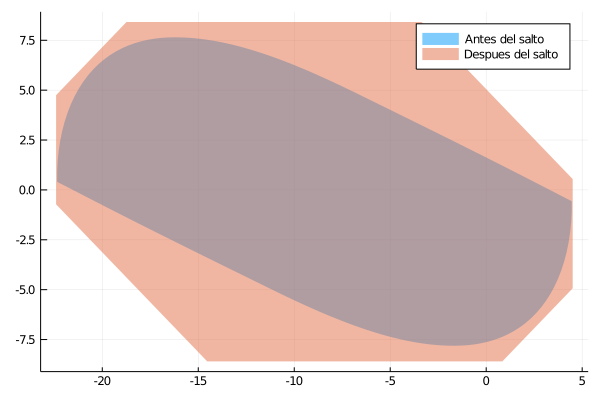

In [11]:
vars = (1, 2)
plot(Projection(set(sol[2][end]), vars), vars=vars, label="Antes del salto", lw=0, fmt=:png)
plot!(sol[3][1],vars=vars, label="Despues del salto", lw=0)

In [17]:
vars = (1, 2)
plot(Projection(set(sol[2][end]), vars), vars=vars, label="Antes del salto", lw=0, fmt=:png)
plot!(Projection(intersection(set(sol[2][end]), Hyperplane(t == 5, var)), vars), vars=vars, lw=0)

LoadError: OverflowError: binomial(1000, 9) overflows

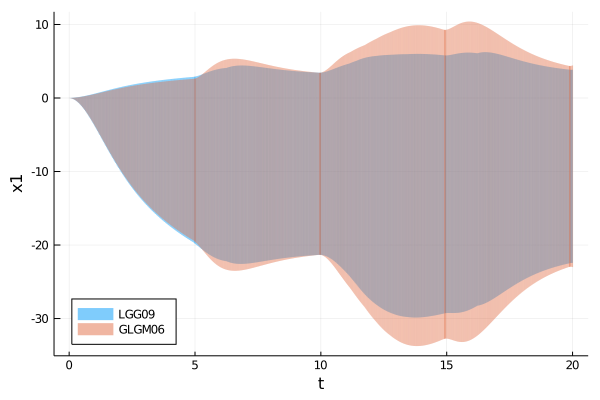

In [29]:
vars = (0, 1)
plot(sol_PLAD01_BND30, vars=vars, xlab="t", ylab="x1", label="LGG09", lw=0, legend=:bottomleft, fmt=:png)
plot!(sol, vars=vars, xlab="t", ylab="x1", label="GLGM06", lw=0)

Here `approx_model=Forward(setops=octdirs)` passed to the `LGG09` solver
makes it overapproximate the set *after* discretization with the template directions.
Othewise, the set would be lazy by default. This option gives a gain in runtime,
since evaluating the 200 dimensions of the template is quite expensive.

Verifying that the specification holds:

In [30]:
dmin_specification(sol_PLAD01_BND30, 30)

false

Let's check in more detail how close is the flowpipe to the safety conditions:

In [31]:
@show -ρ(sparsevec([1], [-1.0], 10), sol_PLAD01_BND30)
@show -ρ(sparsevec([4], [-1.0], 10), sol_PLAD01_BND30)
@show -ρ(sparsevec([7], [-1.0], 10), sol_PLAD01_BND30);

-(ρ(sparsevec([1], [-1.0], 10), sol_PLAD01_BND30)) = -29.862721575258067
-(ρ(sparsevec([4], [-1.0], 10), sol_PLAD01_BND30)) = -26.167902001889445
-(ρ(sparsevec([7], [-1.0], 10), sol_PLAD01_BND30)) = -12.696657569596855


In [82]:
@show -ρ(sparsevec([1], [-1.0], 10), sol)
@show -ρ(sparsevec([4], [-1.0], 10), sol)
@show -ρ(sparsevec([7], [-1.0], 10), sol);

-(ρ(sparsevec([1], [-1.0], 10), sol)) = -42.33200047201423
-(ρ(sparsevec([4], [-1.0], 10), sol)) = -45.91891349314337
-(ρ(sparsevec([7], [-1.0], 10), sol)) = -34.197894196381384


We plot variable ``x_1`` vs time.

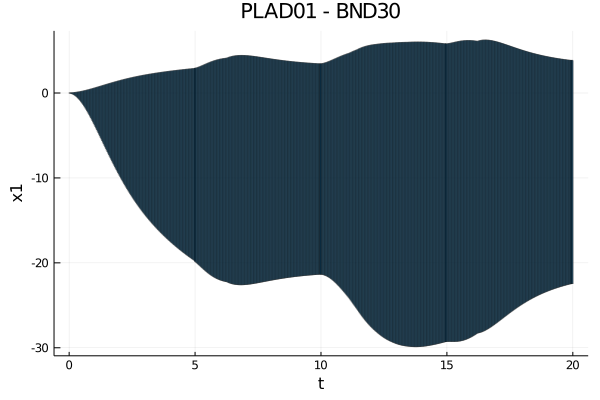

In [37]:
using Plots

plot(sol_PLAD01_BND30, vars=(0, 1), xlab="t", ylab="x1", title="PLAD01 - BND30", fmt=:png)

In [41]:
prob_PLAD01_BND42 = platoon(; deterministic_switching=true)
@time sol_PLAD01_BND42 = solve(prob_PLAD01_BND42, alg=BOX(δ=0.01),
                         clustering_method=BoxClustering(1),
                         intersection_method=TemplateHullIntersection(BoxDirections(10)),
                         intersect_source_invariant=false,
                         tspan = (0.0 .. 20.0));

  0.144684 seconds (521.98 k allocations: 54.346 MiB)


In [43]:
property = -ρ(sparsevec([1], [-1.0], 10), sol_PLAD01_BND42)

-41.366377912095516

In [81]:
alg = GLGM06(δ=0.05, max_order=5);
@time sol42 = solve(prob_PLAD01_BND30,
                  alg=alg,
                  clustering_method=ZonotopeClustering(),
                  intersect_source_invariant=false,
                  intersection_method=ReachabilityAnalysis.TemplateHullIntersectionZonotope(octdirs),
                  tspan = (0.0 .. 20.0));

  0.608595 seconds (5.75 M allocations: 340.161 MiB)


In [78]:
property = -ρ(sparsevec([1], [-1.0], 10), sol42)

-40.97677085190363